In [1]:
import json

# %matplotlib widget
# %matplotlib notebook
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# https://stackoverflow.com/a/37704379
def nested_get(dic, keys):    
    for key in keys:
        dic = dic[key]
    return dic


def read_data(fp):
    data = []
    with open(fp) as f:
        for line in f:
            data.append(json.loads(line))
    
    return data


# Returns just the object fields we care about
def wrangle(res):
    props = {
        "query":            "config.query",
        "faster_copy":      "extra.faster_copy",
        "num_events":       "perf.numEvents",
        "num_results":      "perf.numResults",
        "events_per_sec":   "perf.eventsPerSec",
        "results_per_sec":  "perf.resultsPerSec",
        "runtime_sec":      "perf.runtimeSec",
        "event_bytes_per_sec": "perf.eventBytesPerSec",
        "result_bytes_per_sec": "perf.resultBytesPerSec",
        "coder":            "config.coderStrategy",
        "avg_auction_size": "config.avgAuctionByteSize",
        "avg_bid_size":     "config.avgBidByteSize",
        "avg_person_size":  "config.avgPersonByteSize",
        "parallelism": "extra.parallelism",
    }
    ret = {name: nested_get(res["Result"], keys.split(".")) for name, keys in props.items()}
    return ret

# Battery 03

This battery of tests varies over: query, coder, faster copy. Each run is repeated 10 times.
The parallalism is 2

In [2]:
def bat3_convert_to_df(wr):
    df = pd.DataFrame.from_records(wr)
    df["coder"] = df["coder"].astype("category")
    df["query"] = df["query"].astype("category")

    # We do some preprocessing here.
    df = df.set_index(["query", "coder", "faster_copy"]).sort_index()

    return df

## Loading the data

We load the data from the dump from the go program

In [3]:
bat3_all = read_data("../results/battery03/wow.json")
bat3_good = [wrangle(r) for r in bat3_all if r["Status"] == "OK"]
df =  bat3_convert_to_df(bat3_good)

## Question 1: How does `faster_copy` affect the different queries for normal queries

In [4]:
bf = df.xs(True, level=2) / df.xs(False, level=2)
bf = bf["events_per_sec"]

In [5]:
gg = bf.groupby(["query", "coder"]).agg(["mean", "std"])

In [6]:
jep = gg.unstack()["mean"].sort_values("HAND") - 1

In [7]:
jep

coder,AVRO,HAND,JAVA
query,,,
HIGHEST_BID,-0.006906,-0.024286,0.018924
USER_SESSIONS,0.016375,0.014112,NaN
BOUNDED_SIDE_INPUT_JOIN,0.024461,0.019769,NaN
AVERAGE_SELLING_PRICE_BY_SELLER,0.111259,0.081415,NaN
WINNING_BIDS,0.118262,0.096236,NaN
AVERAGE_PRICE_FOR_CATEGORY,0.109512,0.105380,NaN
SESSION_SIDE_INPUT_JOIN,0.158041,0.155035,NaN
HOT_ITEMS,0.287695,0.223407,NaN
PROCESSING_TIME_WINDOWS,0.352162,0.279736,NaN


<AxesSubplot:ylabel='query'>

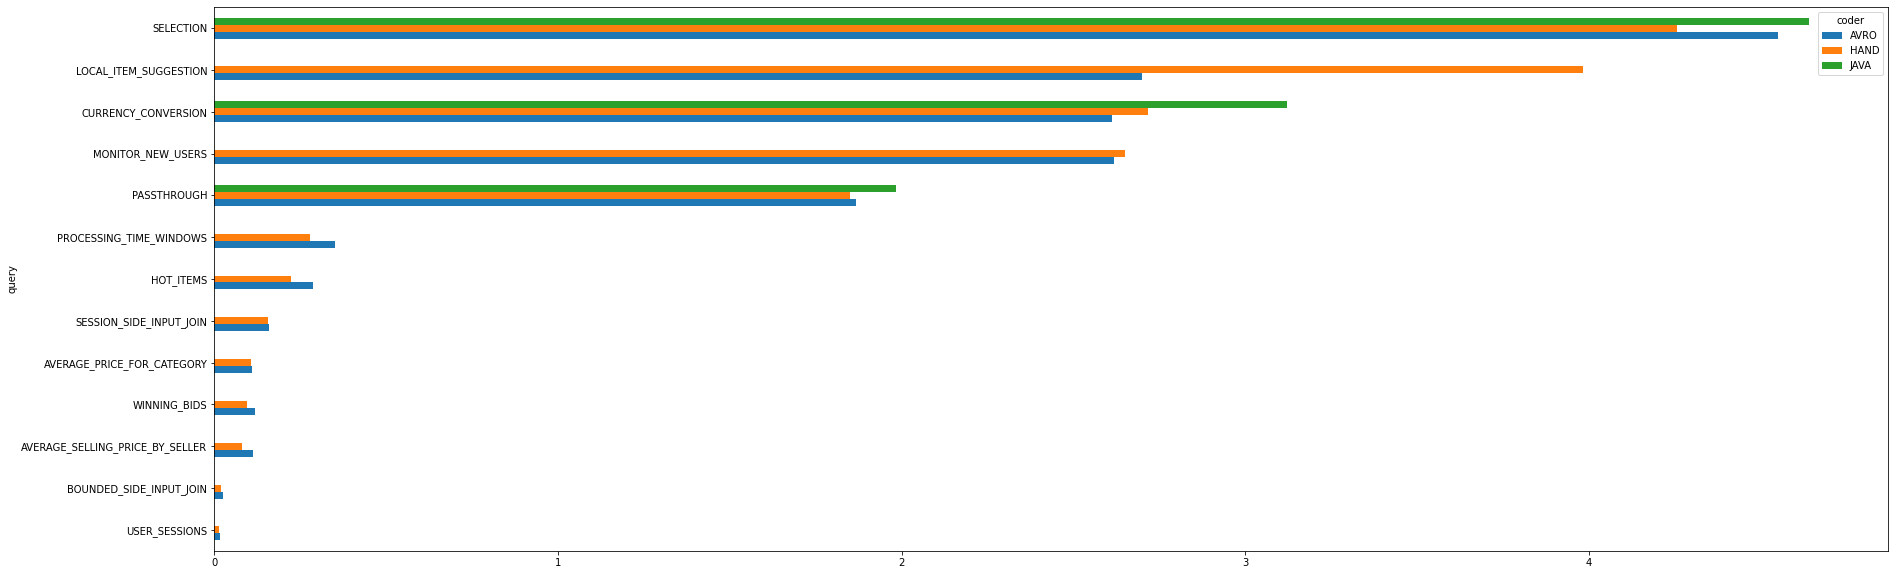

In [8]:
jep[(jep.isna() | (jep > 0)).all(axis=1)].plot(kind="barh", figsize=(30,10))

Apparently the change is minimal between runners. The java serialiser only works
for certain queries. An outlier here is the `LOCAL_ITEM_SUGGESTION` query
where the `HAND` encoder perform a lot better.

One guess is that the queries which output a lot of records in the results would
be hit the hardest. We test this out.

In [9]:
results = df["num_results"].groupby("query").mean()

<AxesSubplot:ylabel='query'>

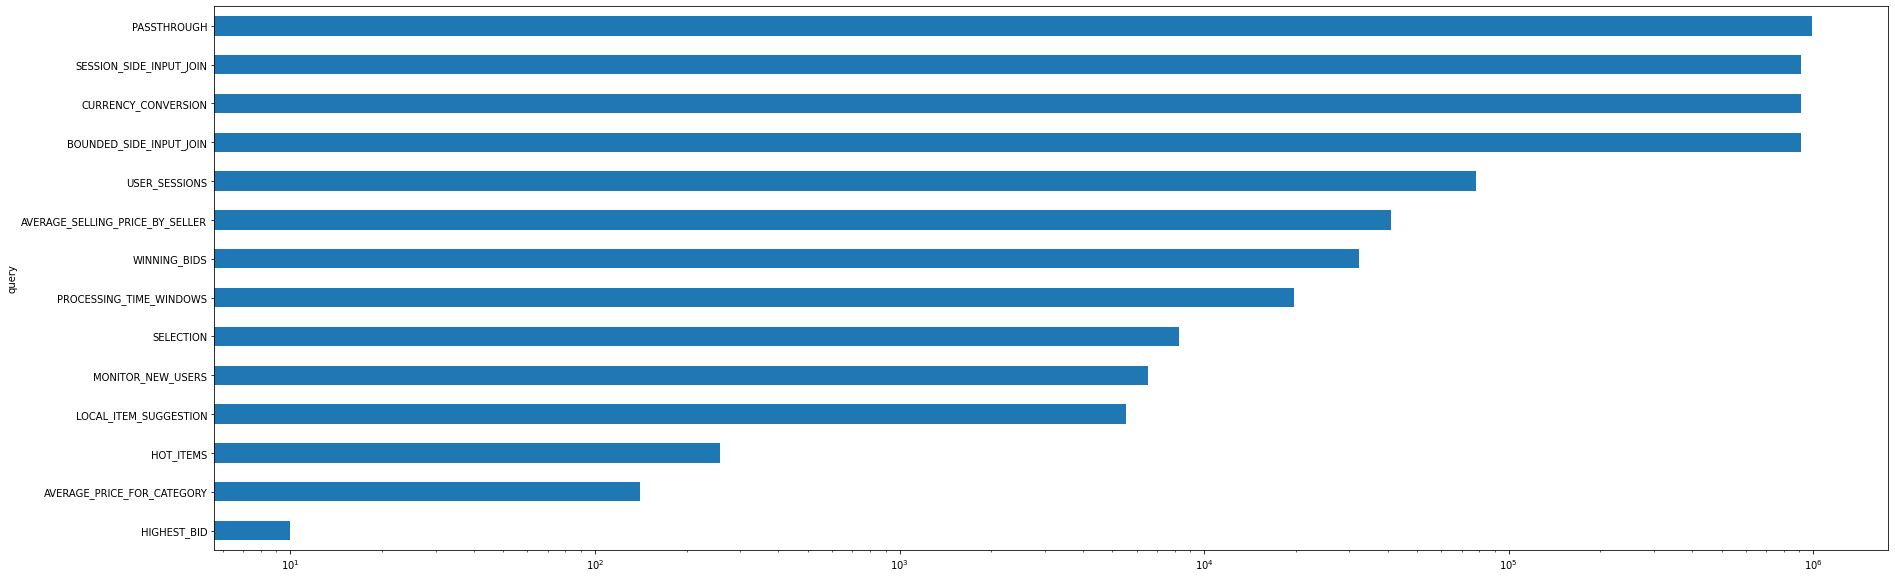

In [10]:
results.sort_values().plot(kind="barh", figsize=(30,10), logx=True)

Based on these results, this doesn't seem to be the case. It might be number of operators?

The `HIGHEST_BID` takes a lot of time to run and stalles, so it has been excluded from later benchmarks.

Since we have seen that the coders doesn't matter, let's look at just the hand coded results.

## Battery04: Does paralleism affect the speedup?

This battery tests if the number of parallel operators change how affected the benchmark is.
If there is no interplay here, there effect should simply be multiplied by the number of
paralllelism.

In [11]:
def bat4_convert_to_df(wr):
    df = pd.DataFrame.from_records(wr)
    df["coder"] = df["coder"].astype("category")
    df["query"] = df["query"].astype("category")

    # We do some preprocessing here.
    df = df.set_index(["query", "parallelism", "faster_copy", ]).sort_index()

    return df

In [12]:
bat4_all = read_data("../results/bat04-06.json")
bat4_good = [wrangle(r) for r in bat4_all if r["Status"] == "OK"]
df =  bat4_convert_to_df(bat4_good)

In [13]:
ef = df["events_per_sec"]

In [14]:
gf = ef.groupby(ef.index.names).agg("mean")

In [15]:
lf = gf.xs(True, level=2) / gf.xs(False, level=2)

In [16]:
jf = lf.unstack()

In [17]:
gg = pd.concat([(jf[2] / jf[1]).rename("2/1"), (jf[4] / jf[2]).rename("4/2")], axis=1, names=["2/1", "4/2"])
gg

,2/1,4/2
query,,
AVERAGE_PRICE_FOR_CATEGORY,0.977847,0.999534
AVERAGE_SELLING_PRICE_BY_SELLER,0.939174,0.993531
BOUNDED_SIDE_INPUT_JOIN,NaN,NaN
CURRENCY_CONVERSION,0.967735,0.999929
HIGHEST_BID,NaN,NaN
HOT_ITEMS,0.968395,1.063078
LOCAL_ITEM_SUGGESTION,0.976152,0.910380
MONITOR_NEW_USERS,0.946234,0.903425
PASSTHROUGH,0.961369,1.009984


## Battery05: Does record size matter?

Change the size of the events to see if it has any effect. The idea is that
since the flink runner needs to marshal and unmarshal more.

The idea is to run adjust the bid size and use the currency converter as
it takes bids in and returns bids out.

In [18]:
def bat5_convert_to_df(wr):
    df = pd.DataFrame.from_records(wr)
    df["coder"] = df["coder"].astype("category")
    df["query"] = df["query"].astype("category")

    # We do some preprocessing here.
    df = df.set_index(["avg_bid_size", "faster_copy"]).sort_index()

    return df

In [19]:
bat5_all = read_data("../results/bat05-03.json")
bat5_good = [wrangle(r) for r in bat5_all if r["Status"] == "OK"]
df =  bat5_convert_to_df(bat5_good)

In [20]:
kk = df["events_per_sec"].xs(True, level=1) / df["events_per_sec"].xs(False, level=1)

<AxesSubplot:xlabel='avg_bid_size'>

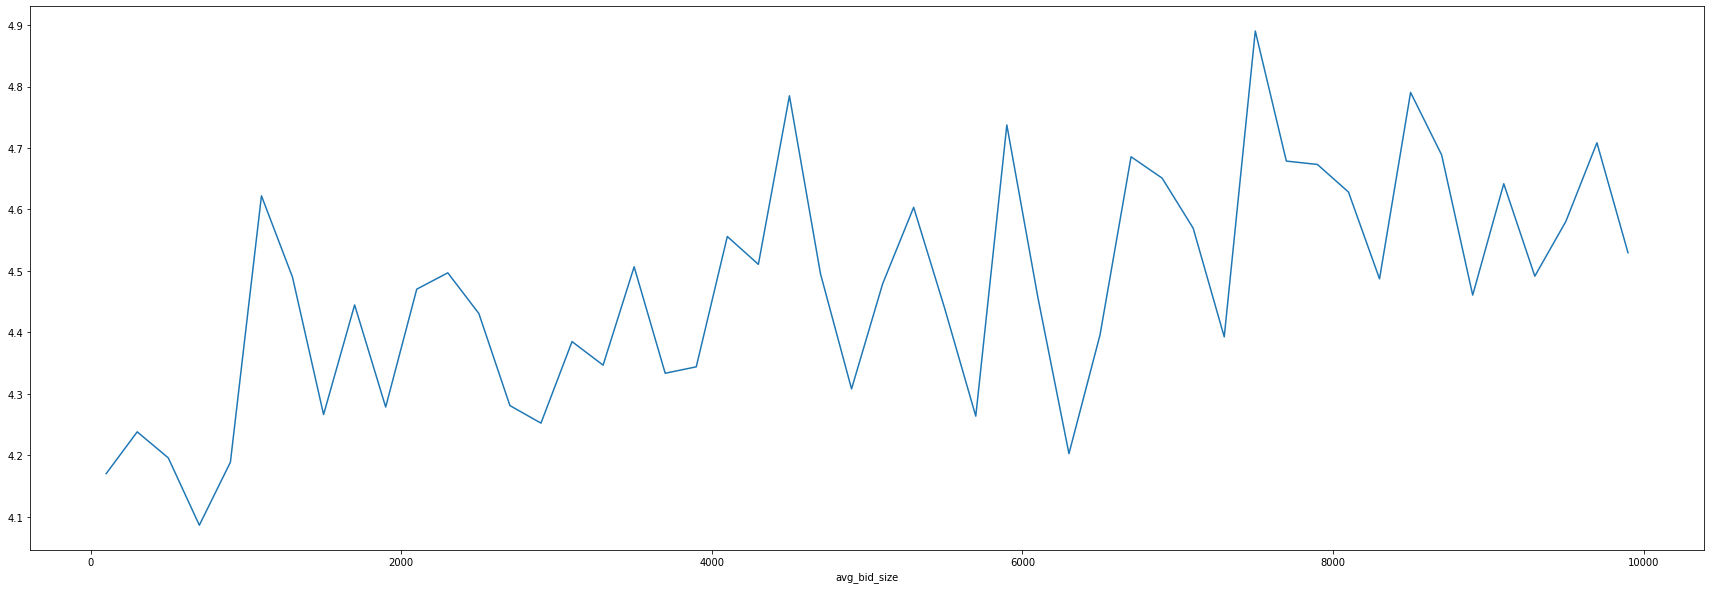

In [29]:
kk.groupby("avg_bid_size").mean().plot(figsize=(30,10))

Here it seems there is some increase, but it is minimal. The size has increased 10x fold, but the ratio has not
We are running the queries with more stances now.

Running with more seems to bear out the same conclusion, that it didn't really change much. This hints at the fact that the
bid size doesn't really have a say.

In [22]:
bb = df["event_bytes_per_sec"].xs(True, level=1) / df["event_bytes_per_sec"].xs(False, level=1)

<AxesSubplot:xlabel='avg_bid_size'>

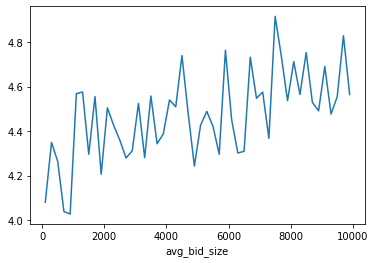

In [23]:
bb.groupby("avg_bid_size").median().plot()

In [24]:
df

query  num_events  num_results  \
avg_bid_size faster_copy                                                 
100          False        CURRENCY_CONVERSION     4958415      4561739   
             False        CURRENCY_CONVERSION     4958415      4561739   
             False        CURRENCY_CONVERSION     4958415      4561739   
             False        CURRENCY_CONVERSION     4958415      4561739   
             False        CURRENCY_CONVERSION     4958415      4561739   
...                                       ...         ...          ...   
9900         True         CURRENCY_CONVERSION     4958415      4561739   
             True         CURRENCY_CONVERSION     4958415      4561739   
             True         CURRENCY_CONVERSION     4958415      4561739   
             True         CURRENCY_CONVERSION     4958415      4561739   
             True         CURRENCY_CONVERSION     4958415      4561739   

                          events_per_sec  results_per_sec  runtime_sec  \
avg_bid_size faster_copy                                                 
100          False         376979.776477    346821.181480       13.153   
             False         340550.480769    313306.250000       14.560   
             False         323487.408664    297608.233299       15.328   
             False         306794.641752    282250.897166       16.162   
             False         288464.424923    265387.108034       17.189   
...                                  ...              ...          ...   
9900         True           89345.640305     82197.938627       55.497   
             True           71844.427379     66096.832619       69.016   
             True           82349.282535     75761.293430       60.212   
             True           79167.438370     72833.998595       62.632   
             True           73485.216747     67606.357910       67.475   

                          event_bytes_per_sec  result_bytes_per_sec coder  \
avg_bid_size faster_copy                                                    
100          False               4.838960e+07          3.485480e+07  HAND   
             False               4.371349e+07          3.148662e+07  HAND   
             False               4.152326e+07          2.990900e+07  HAND   
             False               3.938055e+07          2.836562e+07  HAND   
             False               3.702766e+07          2.667085e+07  HAND   
...                                       ...                   ...   ...   
9900         True                8.170005e+08          8.137927e+08  HAND   
             True                6.569647e+08          6.543853e+08  HAND   
             True                7.530239e+08          7.500673e+08  HAND   
             True                7.239283e+08          7.210859e+08  HAND   
             True                6.719685e+08          6.693302e+08  HAND   

                          avg_auction_size  avg_person_size  parallelism  
avg_bid_size faster_copy                                                  
100          False                     500              200            8  
             False                     500              200            8  
             False                     500              200            8  
             False                     500              200            8  
             False                     500              200            8  
...                                    ...              ...          ...  
9900         True                      500              200            8  
             True                      500              200            8  
             True                      500              200            8  
             True                      500              200            8  
             True                      500              200            8  

[1000 rows x 12 columns]

<AxesSubplot:xlabel='avg_bid_size'>

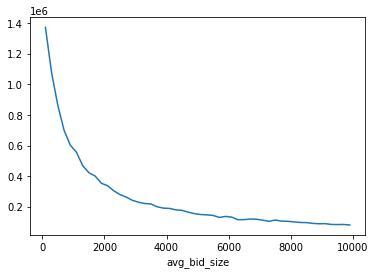

In [25]:
df.xs(True, level=1).groupby("avg_bid_size")["events_per_sec"].mean().plot()

<AxesSubplot:xlabel='avg_bid_size'>

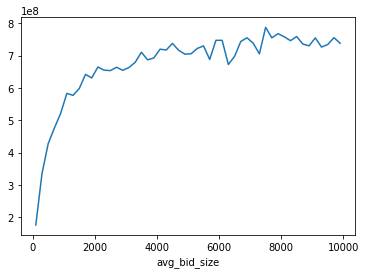

In [26]:
df.xs(True, level=1).groupby("avg_bid_size")["event_bytes_per_sec"].mean().plot()